In [1]:
import numpy as np 
import os
from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from tqdm import tqdm

import cv2 
import copy
%matplotlib inline

# Load data

In [2]:
bike_dir = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset/Bike'
car_dir = '/kaggle/input/car-vs-bike-classification-dataset/Car-Bike-Dataset/Car'

bike_files = [os.path.join(bike_dir, f) for f in os.listdir(bike_dir) if os.path.getsize(os.path.join(bike_dir, f)) > 0 ]
car_files = [os.path.join(car_dir, f) for f in os.listdir(car_dir) if os.path.getsize(os.path.join(car_dir, f)) > 0 ]

all_files = bike_files + car_files
labels = [0] * len(bike_files) + [1] * len(car_files)

In [3]:
np.unique(np.array(labels), return_counts=True)

(array([0, 1]), array([2000, 2000]))

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    all_files, 
    labels,
    test_size=0.2,
    random_state=42,
    stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, 
    y_train,
    test_size=0.1,
    random_state=42,
    stratify=y_train
)

In [5]:
class MyDataset(Dataset):
    def __init__(self, filepaths, labels, transform=None):
        self.filepaths = filepaths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.filepaths)

    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path).convert('RGB')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, label

In [6]:
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(0.5), 
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(256),             
    transforms.CenterCrop(224),         
    transforms.ToTensor(),              
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = MyDataset(X_train, y_train, transform=train_transforms)
val_dataset = MyDataset(X_val, y_val, transform=val_test_transforms)
test_dataset = MyDataset(X_test, y_test, transform=val_test_transforms)

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Images with normalization:


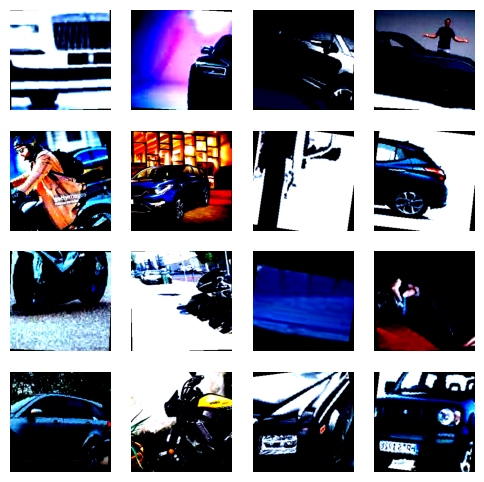

In [8]:
# Function for vusialisation images from batch
def show_images(images, denormalize=False):
    if denormalize:
        # Denormalization 
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        images = images.numpy().transpose((0, 2, 3, 1))
        images = std * images + mean
        images = np.clip(images, 0, 1)
    else:
        images = images.numpy().transpose((0, 2, 3, 1))
    fig, axes = plt.subplots(4, 4, figsize=(6, 6))
    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i])
        ax.axis('off')
    plt.show()

# First batch from train loader
images, _ = next(iter(train_loader))

print("Images with normalization:")
show_images(images, denormalize=False)

Images without normalization:


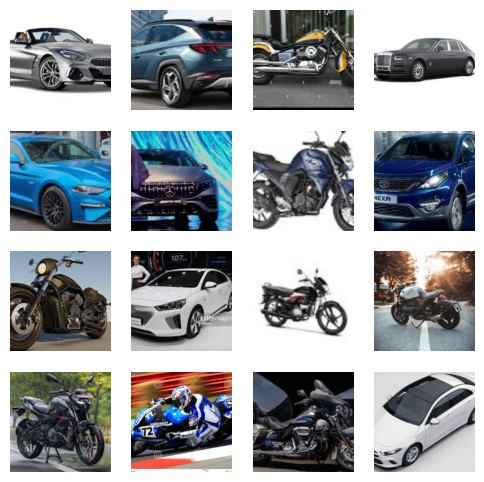

In [9]:
images, _ = next(iter(test_loader))

print("Images without normalization:")
show_images(images, denormalize=True)

# Models

## Baseline ResNet18 with fc training

### Training

In [10]:
def train_model(model, train_loader, val_loader, num_epochs, criterion, optimizer, patience=5, scheduler=None, unfreeze_fn=None, device="cuda"):
    train_losses, train_accuracies = [], []
    val_losses, val_accuracies = [], []
    
    best_val_accuracy = 0
    best_model_wts = copy.deepcopy(model.state_dict())
    iter_without_improvements = 0

    model.to(device)

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # If have unfreeze
        if unfreeze_fn is not None:
            unfreeze_fn(model, epoch)

        model.train()
        train_loss, correct, total = 0.0, 0, 0
        for images, labels in tqdm(train_loader, desc="Train"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
            train_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            total += labels.size(0)
    
        train_loss /= total
        train_accuracy = correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Val"):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
            
                val_loss += loss.item() * images.size(0)
                _, predicted = outputs.max(1)
                correct += predicted.eq(labels).sum().item()
                total += labels.size(0)
    
        val_loss /= total
        val_accuracy = correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        print(f"Train loss: {train_loss:.4f}, acc: {train_accuracy:.4f} | "
              f"Val loss: {val_loss:.4f}, acc: {val_accuracy:.4f}")
        
        if scheduler is not None:
            scheduler.step()
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            iter_without_improvements = 0
            best_model_wts = copy.deepcopy(model.state_dict())
        else: 
            iter_without_improvements += 1
            if iter_without_improvements > patience:
                print("Early stopping")
                break

    model.load_state_dict(best_model_wts)
    return model, train_losses, train_accuracies, val_losses, val_accuracies

In [12]:
num_classes = 2
criterion = nn.CrossEntropyLoss()
num_epochs = 70
patience = 5

In [13]:
model_Resnet18_fc = models.resnet18(pretrained=True)
model_Resnet18_fc.fc = nn.Linear(model_Resnet18_fc.fc.in_features, num_classes)
model_Resnet18_fc = model_Resnet18_fc.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 160MB/s] 


In [14]:
for param in model_Resnet18_fc.parameters():
    param.requires_grad = False
for param in model_Resnet18_fc.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(model_Resnet18_fc.parameters(), lr=1e-4)
model_Resnet18_fc, train_losses_ResNet18_fc, train_accuracies_ResNet18_fc, val_losses_ResNet18_fc, val_accuracies_ResNet18_fc = train_model(model_Resnet18_fc, train_loader, val_loader, 50, criterion, optimizer, patience=7)


Epoch 1/50


Train:  47%|████▋     | 21/45 [00:05<00:04,  4.96it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  53%|█████▎    | 24/45 [00:06<00:06,  3.05it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  3.56it/s]


Train loss: 0.6467, acc: 0.6375 | Val loss: 0.5065, acc: 0.7969

Epoch 2/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   7%|▋         | 3/45 [00:00<00:12,  3.42it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  62%|██████▏   | 28/45 [00:05<00:02,  8.21it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Train loss: 0.5281, acc: 0.7767 | Val loss: 0.3834, acc: 0.8938

Epoch 3/50


Train:  51%|█████     | 23/45 [00:03<00:02,  7.98it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  60%|██████    | 27/45 [00:04<00:02,  8.35it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  62%|██████▏   | 28/45 [00:04<00:02,  7.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Train loss: 0.4418, acc: 0.8497 | Val loss: 0.2988, acc: 0.9437

Epoch 4/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  22%|██▏       | 10/45 [00:02<00:05,  6.35it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  62%|██████▏   | 28/45 [00:04<00:01,  8.78it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.73it/s]


Train loss: 0.3836, acc: 0.8809 | Val loss: 0.2464, acc: 0.9594

Epoch 5/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   9%|▉         | 4/45 [00:01<00:09,  4.15it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.97it/s]


Train loss: 0.3383, acc: 0.9062 | Val loss: 0.2068, acc: 0.9719

Epoch 6/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  20%|██        | 9/45 [00:03<00:15,  2.34it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.89it/s]


Train loss: 0.3021, acc: 0.9198 | Val loss: 0.1748, acc: 0.9812

Epoch 7/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   7%|▋         | 3/45 [00:01<00:15,  2.70it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  44%|████▍     | 20/45 [00:04<00:03,  7.08it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.49it/s]


Train loss: 0.2780, acc: 0.9194 | Val loss: 0.1532, acc: 0.9812

Epoch 8/50


Train:   2%|▏         | 1/45 [00:00<00:26,  1.68it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  29%|██▉       | 13/45 [00:02<00:04,  7.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Train loss: 0.2628, acc: 0.9278 | Val loss: 0.1360, acc: 0.9844

Epoch 9/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  31%|███       | 14/45 [00:02<00:04,  7.63it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:00<00:00,  5.04it/s]


Train loss: 0.2453, acc: 0.9271 | Val loss: 0.1216, acc: 0.9844

Epoch 10/50


Train:  24%|██▍       | 11/45 [00:01<00:04,  8.50it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  60%|██████    | 27/45 [00:04<00:02,  6.61it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  64%|██████▍   | 29/45 [00:04<00:02,  7.90it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  80%|████████  | 36/45 [00:05<00:01,  8.64it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.62it/s]


Train loss: 0.2343, acc: 0.9309 | Val loss: 0.1123, acc: 0.9844

Epoch 11/50


Train:  16%|█▌        | 7/45 [00:01<00:05,  7.32it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  18%|█▊        | 8/45 [00:01<00:07,  5.10it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  58%|█████▊    | 26/45 [00:04<00:03,  5.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.79it/s]


Train loss: 0.2082, acc: 0.9444 | Val loss: 0.1058, acc: 0.9844

Epoch 12/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  13%|█▎        | 6/45 [00:01<00:07,  5.44it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  22%|██▏       | 10/45 [00:03<00:09,  3.51it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:00<00:00,  5.01it/s]


Train loss: 0.2066, acc: 0.9403 | Val loss: 0.0968, acc: 0.9875

Epoch 13/50


Train:   2%|▏         | 1/45 [00:00<00:27,  1.62it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   4%|▍         | 2/45 [00:01<00:35,  1.22it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  73%|███████▎  | 33/45 [00:05<00:01,  8.43it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.53it/s]


Train loss: 0.2076, acc: 0.9378 | Val loss: 0.0880, acc: 0.9875

Epoch 14/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  27%|██▋       | 12/45 [00:02<00:08,  3.68it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  76%|███████▌  | 34/45 [00:05<00:01,  7.88it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


Train loss: 0.1967, acc: 0.9420 | Val loss: 0.0866, acc: 0.9844

Epoch 15/50


Train:  13%|█▎        | 6/45 [00:02<00:12,  3.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  36%|███▌      | 16/45 [00:03<00:04,  7.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  47%|████▋     | 21/45 [00:04<00:03,  7.22it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.76it/s]


Train loss: 0.1817, acc: 0.9462 | Val loss: 0.0793, acc: 0.9906

Epoch 16/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  20%|██        | 9/45 [00:02<00:06,  5.83it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  29%|██▉       | 13/45 [00:02<00:04,  6.61it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  82%|████████▏ | 37/45 [00:06<00:01,  6.47it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.56it/s]


Train loss: 0.1787, acc: 0.9396 | Val loss: 0.0781, acc: 0.9875

Epoch 17/50


Train:   4%|▍         | 2/45 [00:01<00:28,  1.49it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  36%|███▌      | 16/45 [00:03<00:03,  7.51it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.44it/s]


Train loss: 0.1821, acc: 0.9441 | Val loss: 0.0747, acc: 0.9875

Epoch 18/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  53%|█████▎    | 24/45 [00:04<00:03,  6.86it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.84it/s]


Train loss: 0.1734, acc: 0.9451 | Val loss: 0.0712, acc: 0.9875

Epoch 19/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  31%|███       | 14/45 [00:03<00:04,  6.45it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  69%|██████▉   | 31/45 [00:05<00:01,  7.67it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.75it/s]


Train loss: 0.1769, acc: 0.9413 | Val loss: 0.0646, acc: 0.9906

Epoch 20/50


Train:   7%|▋         | 3/45 [00:00<00:09,  4.48it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   9%|▉         | 4/45 [00:01<00:12,  3.39it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  13%|█▎        | 6/45 [00:01<00:07,  5.30it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Train loss: 0.1664, acc: 0.9497 | Val loss: 0.0628, acc: 0.9875

Epoch 21/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  76%|███████▌  | 34/45 [00:06<00:01,  5.90it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.54it/s]


Train loss: 0.1677, acc: 0.9441 | Val loss: 0.0611, acc: 0.9906

Epoch 22/50


Train:   2%|▏         | 1/45 [00:00<00:27,  1.60it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  49%|████▉     | 22/45 [00:03<00:03,  7.29it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  89%|████████▉ | 40/45 [00:06<00:00,  7.20it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.63it/s]


Train loss: 0.1607, acc: 0.9403 | Val loss: 0.0607, acc: 0.9906

Epoch 23/50


Train:  33%|███▎      | 15/45 [00:03<00:05,  5.21it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  60%|██████    | 27/45 [00:05<00:02,  7.98it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  64%|██████▍   | 29/45 [00:05<00:02,  7.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.40it/s]

Train loss: 0.1582, acc: 0.9479 | Val loss: 0.0564, acc: 0.9906
Early stopping


### Result

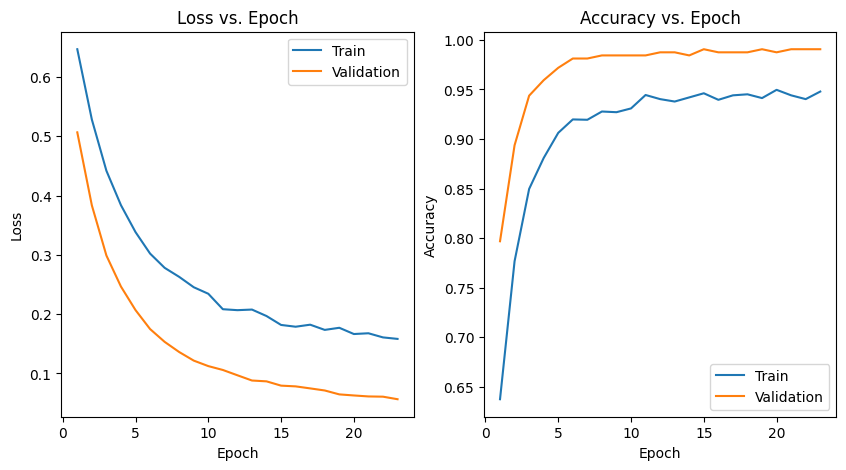

In [16]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_ResNet18_fc)+1), train_losses_ResNet18_fc, label='Train')
plt.plot(range(1, len(val_losses_ResNet18_fc)+1), val_losses_ResNet18_fc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_ResNet18_fc)+1), train_accuracies_ResNet18_fc, label='Train')
plt.plot(range(1, len(val_accuracies_ResNet18_fc)+1), val_accuracies_ResNet18_fc, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

In [15]:
# Model prediction result
def evaluate_model(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())
            
    cm = confusion_matrix(y_true, y_pred)
    report = classification_report(y_true, y_pred)
    accuracy = np.sum(np.diag(cm)) / np.sum(cm)
    
    # Calcs f1 weighted score
    weighted_f1 = f1_score(y_true, y_pred, average='weighted')
    return cm, report, accuracy, weighted_f1

# Visualisation confusion matrix
def plot_confusion_matrix(cm, classes):
    with plt.style.context('default'):  
        plt.figure(figsize=(5, 4))
        sns.set(font_scale=1.0)
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False,
                    xticklabels=classes, yticklabels=classes)
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98       400
           1       0.97      0.99      0.98       400

    accuracy                           0.98       800
   macro avg       0.98      0.98      0.98       800
weighted avg       0.98      0.98      0.98       800

Test Accuracy: 0.9812


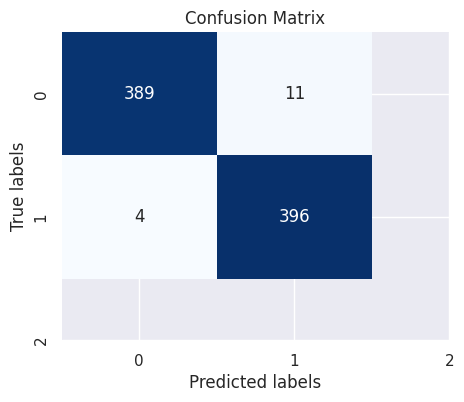

In [17]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_Resnet18_fc, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

## Resnet18 with gradual unfreeze

### Training

In [18]:
model_Resnet18_grad = models.resnet18(pretrained=True)
model_Resnet18_grad.fc = nn.Linear(model_Resnet18_grad.fc.in_features, num_classes)
model_Resnet18_grad = model_Resnet18_grad.to(device)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [19]:
def gradual_unfreeze(model, epoch):
    if epoch == 5:
        for param in model.layer4.parameters():
            param.requires_grad = True
    if epoch == 10:
        for param in model.layer3.parameters():
            param.requires_grad = True
    if epoch == 15:
        for param in model.layer2.parameters():
            param.requires_grad = True

In [20]:
for param in model_Resnet18_grad.parameters():
    param.requires_grad = False
for param in model_Resnet18_grad.fc.parameters():
    param.requires_grad = True

optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model_Resnet18_grad.parameters()), lr=1e-3)
model_Resnet18_grad, train_losses_ResNet18_grad, train_accuracies_ResNet18_grad, val_losses_ResNet18_grad, val_accuracies_ResNet18_grad = train_model(model_Resnet18_grad, train_loader, val_loader, 50, criterion, optimizer, patience=5, unfreeze_fn=gradual_unfreeze)


Epoch 1/50


Train:   4%|▍         | 2/45 [00:00<00:16,  2.63it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  22%|██▏       | 10/45 [00:03<00:11,  3.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  40%|████      | 18/45 [00:04<00:04,  5.80it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  82%|████████▏ | 37/45 [00:07<00:01,  7.11it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  3.92it/s]


Train loss: 0.3471, acc: 0.8663 | Val loss: 0.0985, acc: 0.9844

Epoch 2/50


Train:   7%|▋         | 3/45 [00:00<00:11,  3.77it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  42%|████▏     | 19/45 [00:03<00:03,  8.19it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  76%|███████▌  | 34/45 [00:05<00:01,  7.80it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Train loss: 0.1945, acc: 0.9288 | Val loss: 0.0642, acc: 0.9906

Epoch 3/50


Train:  38%|███▊      | 17/45 [00:03<00:04,  6.32it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  51%|█████     | 23/45 [00:04<00:02,  8.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  60%|██████    | 27/45 [00:04<00:02,  7.94it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.32it/s]


Train loss: 0.1551, acc: 0.9465 | Val loss: 0.0451, acc: 0.9875

Epoch 4/50


Train:   2%|▏         | 1/45 [00:00<00:31,  1.40it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  24%|██▍       | 11/45 [00:02<00:05,  6.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  56%|█████▌    | 25/45 [00:04<00:03,  6.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Train loss: 0.1342, acc: 0.9528 | Val loss: 0.0416, acc: 0.9906

Epoch 5/50


Train:  33%|███▎      | 15/45 [00:03<00:05,  5.35it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  42%|████▏     | 19/45 [00:04<00:03,  6.99it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  69%|██████▉   | 31/45 [00:06<00:01,  7.37it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Train loss: 0.1473, acc: 0.9451 | Val loss: 0.0345, acc: 0.9906

Epoch 6/50


Train:  20%|██        | 9/45 [00:02<00:04,  7.26it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  24%|██▍       | 11/45 [00:03<00:14,  2.33it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  33%|███▎      | 15/45 [00:04<00:06,  4.31it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  38%|███▊      | 17/45 [00:04<00:05,  5.34it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.28it/s]


Train loss: 0.1324, acc: 0.9479 | Val loss: 0.0357, acc: 0.9906

Epoch 7/50


Train:  36%|███▌      | 16/45 [00:03<00:04,  7.18it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  56%|█████▌    | 25/45 [00:04<00:02,  7.20it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  84%|████████▍ | 38/45 [00:07<00:01,  6.56it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.11it/s]


Train loss: 0.1218, acc: 0.9531 | Val loss: 0.0288, acc: 0.9938

Epoch 8/50


Train:  24%|██▍       | 11/45 [00:02<00:05,  6.37it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  31%|███       | 14/45 [00:03<00:05,  5.77it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  44%|████▍     | 20/45 [00:03<00:03,  7.79it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.31it/s]


Train loss: 0.1196, acc: 0.9597 | Val loss: 0.0317, acc: 0.9906

Epoch 9/50


Train:   4%|▍         | 2/45 [00:01<00:24,  1.78it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  73%|███████▎  | 33/45 [00:06<00:01,  7.13it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  76%|███████▌  | 34/45 [00:06<00:01,  7.70it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.24it/s]


Train loss: 0.1287, acc: 0.9451 | Val loss: 0.0332, acc: 0.9906

Epoch 10/50


Train:   2%|▏         | 1/45 [00:00<00:33,  1.32it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   9%|▉         | 4/45 [00:01<00:08,  4.76it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  64%|██████▍   | 29/45 [00:06<00:02,  6.07it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.17it/s]


Train loss: 0.1154, acc: 0.9549 | Val loss: 0.0243, acc: 0.9969

Epoch 11/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  11%|█         | 5/45 [00:02<00:11,  3.48it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.26it/s]


Train loss: 0.1093, acc: 0.9552 | Val loss: 0.0257, acc: 0.9938

Epoch 12/50


Train:   7%|▋         | 3/45 [00:01<00:17,  2.36it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  44%|████▍     | 20/45 [00:03<00:04,  5.04it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  76%|███████▌  | 34/45 [00:07<00:03,  3.26it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.39it/s]


Train loss: 0.1103, acc: 0.9576 | Val loss: 0.0221, acc: 0.9969

Epoch 13/50


Train:   9%|▉         | 4/45 [00:01<00:08,  4.60it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  56%|█████▌    | 25/45 [00:05<00:04,  4.65it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.46it/s]


Train loss: 0.1027, acc: 0.9573 | Val loss: 0.0216, acc: 0.9938

Epoch 14/50


Train:  11%|█         | 5/45 [00:02<00:12,  3.14it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  13%|█▎        | 6/45 [00:03<00:09,  3.99it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  16%|█▌        | 7/45 [00:03<00:07,  4.84it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.61it/s]


Train loss: 0.1196, acc: 0.9524 | Val loss: 0.0206, acc: 0.9969

Epoch 15/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  11%|█         | 5/45 [00:01<00:07,  5.69it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:  73%|███████▎  | 33/45 [00:05<00:01,  8.23it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.38it/s]


Train loss: 0.1012, acc: 0.9580 | Val loss: 0.0239, acc: 0.9938

Epoch 16/50


Train:   0%|          | 0/45 [00:00<?, ?it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   2%|▏         | 1/45 [00:00<00:30,  1.44it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Train:   9%|▉         | 4/45 [00:01<00:09,  4.55it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:1043: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Val: 100%|██████████| 5/5 [00:01<00:00,  4.50it/s]

Train loss: 0.1040, acc: 0.9566 | Val loss: 0.0196, acc: 0.9969
Early stopping


### Result

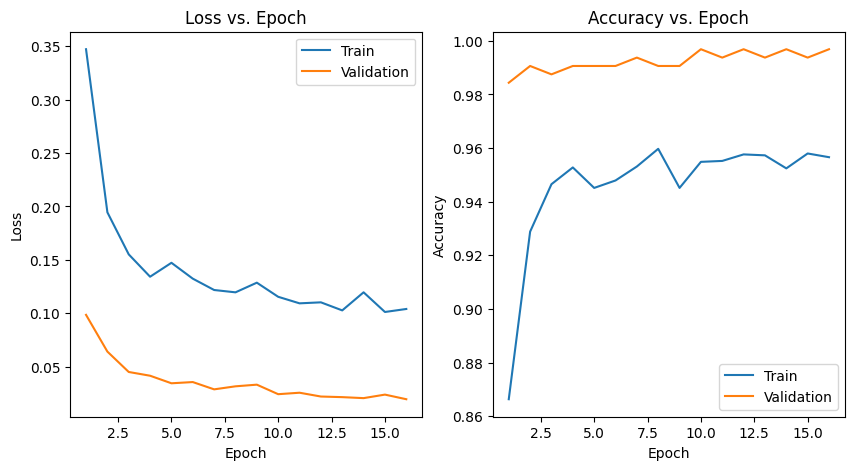

In [21]:
# Model training/validation graph
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, len(train_losses_ResNet18_grad)+1), train_losses_ResNet18_grad, label='Train')
plt.plot(range(1, len(val_losses_ResNet18_grad)+1), val_losses_ResNet18_grad, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, len(train_accuracies_ResNet18_grad)+1), train_accuracies_ResNet18_grad, label='Train')
plt.plot(range(1, len(val_accuracies_ResNet18_grad)+1), val_accuracies_ResNet18_grad, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.legend()

plt.show()

Metrics for current model:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       400
           1       0.99      0.99      0.99       400

    accuracy                           0.99       800
   macro avg       0.99      0.99      0.99       800
weighted avg       0.99      0.99      0.99       800

Test Accuracy: 0.9900


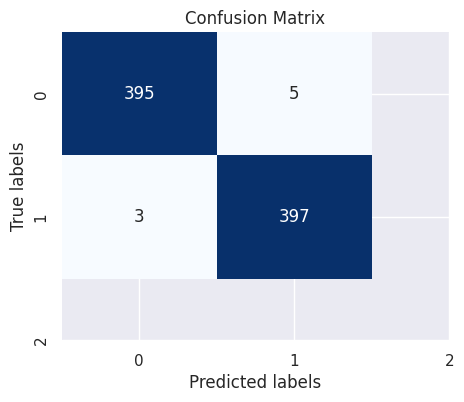

In [22]:
cm, report, accuracy_1, weighted_f1_1 = evaluate_model(model_Resnet18_grad, test_loader)
print("Metrics for current model:")
print(report)
print(f'Test Accuracy: {accuracy_1:.4f}')
plot_confusion_matrix(cm, classes=list(range(3)))

# Where is model looking

In [46]:
class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self.hook_layers()

    def hook_layers(self):
        # Hook for forward
        def forward_hook(module, input, output):
            self.activations = output.detach()

        # Hook for backward
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0].detach()

        # reg hooks
        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx=None):
        self.model.eval() 
        
        input_tensor.requires_grad_(True) 
        
        output = self.model(input_tensor)

        if class_idx is None:
            class_idx = output.argmax(dim=1).item()

        loss = output[0, class_idx]
        
        self.model.zero_grad()
        loss.backward()

        if self.gradients is None or self.activations is None:
            return None

        grads = self.gradients[0].cpu().numpy()  # (C, H, W)
        act = self.activations[0].cpu().numpy()  # (C, H, W)

        weights = np.mean(grads, axis=(1, 2))
        cam = np.zeros(act.shape[1:], dtype=np.float32)

        for i, w in enumerate(weights):
            cam += w * act[i]

        cam = np.maximum(cam, 0)
        cam = cv2.resize(cam, (input_tensor.size(2), input_tensor.size(3)))
        cam = cam - np.min(cam)
        cam = cam / np.max(cam)
        return cam

In [47]:
def get_misclassified(model, dataloader, device):
    model.eval()
    misclassified = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            for i in range(len(images)):
                if preds[i] != labels[i]:
                    misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))
    return misclassified

In [48]:
def compare_gradcam(model1, target_layer1, model2, target_layer2, dataloader, device, n=5):
    gradcam1 = GradCAM(model1, target_layer1)
    gradcam2 = GradCAM(model2, target_layer2)

    errors = get_misclassified(model1, dataloader, device)
    print(f"misstake baseline CNN: {len(errors)}")

    for i in range(min(n, len(errors))):
        img, true_label, pred_label = errors[i]
        input_tensor = img.unsqueeze(0).to(device)

        cam1 = gradcam1.generate(input_tensor)
        cam2 = gradcam2.generate(input_tensor)

        img_np = img.permute(1, 2, 0).numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())

        def overlay(img_np, cam):
            heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
            heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
            return 0.4 * heatmap + 0.6 * (img_np * 255)

        overlay1 = overlay(img_np, cam1)
        overlay2 = overlay(img_np, cam2)

        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img_np)
        plt.title(f"True: {true_label}, Pred: {pred_label}")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(overlay1.astype(np.uint8))
        plt.title("Model 1")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(overlay2.astype(np.uint8))
        plt.title("Model 2")
        plt.axis("off")

        plt.show()

misstake baseline CNN: 15


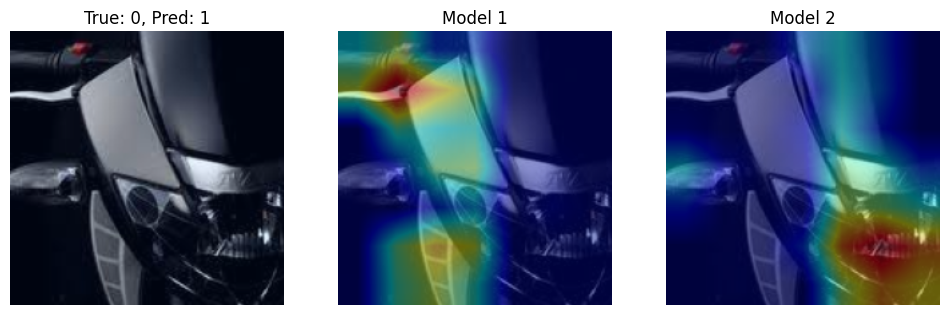

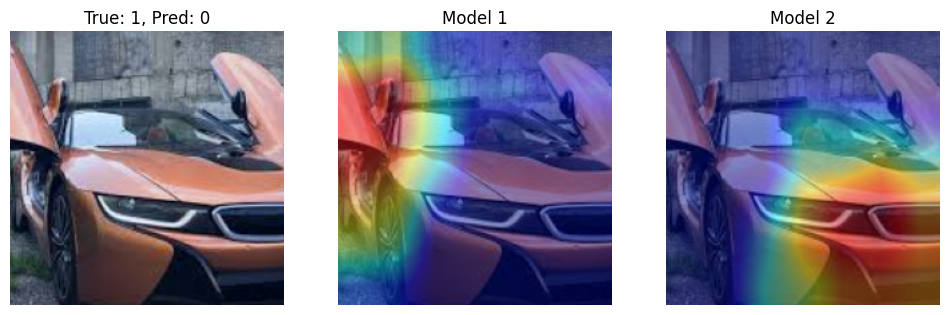

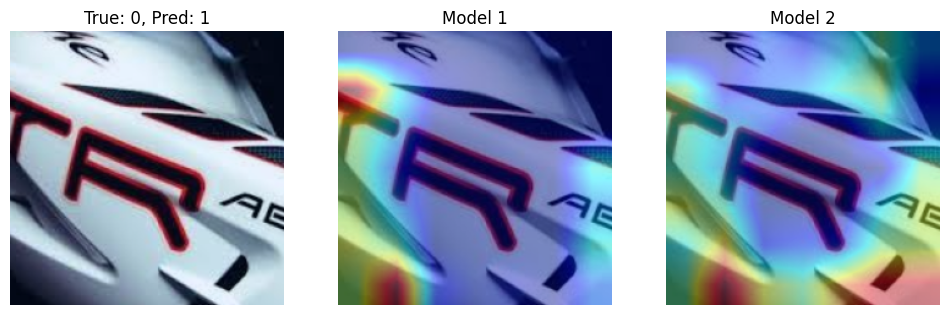

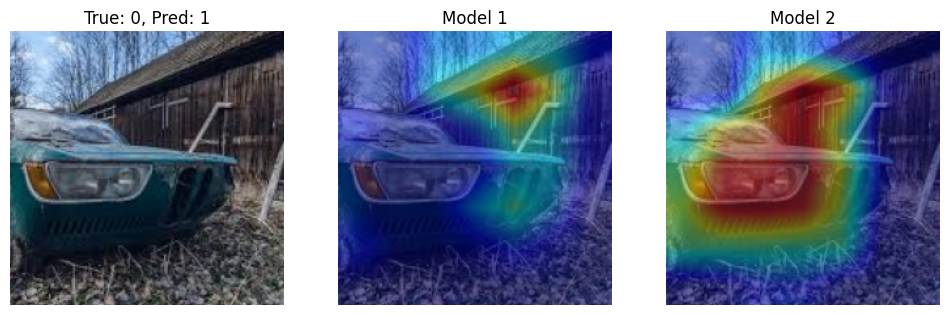

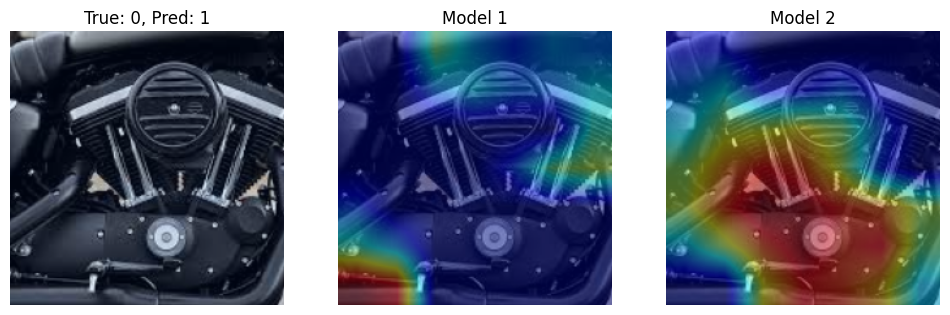

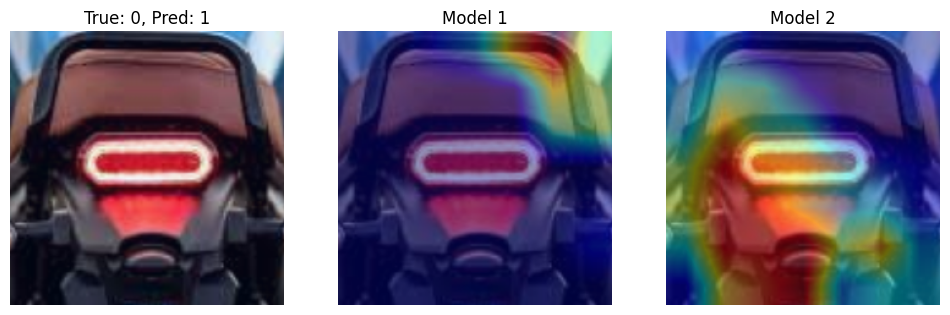

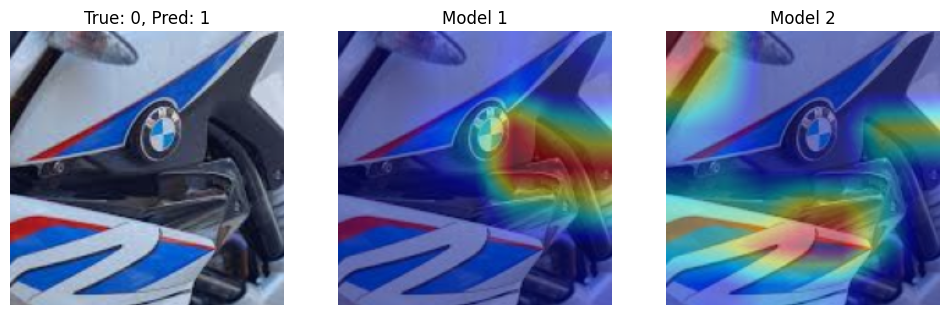

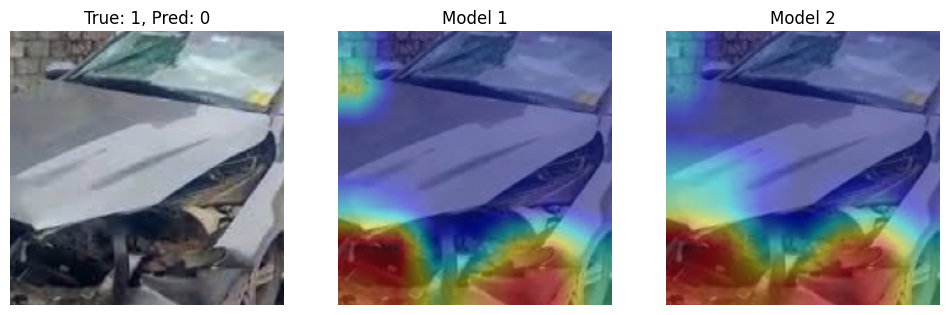

In [49]:
target_layer_baseline = model_Resnet18_fc.layer4[-1]

target_layer_resnet = model_Resnet18_grad.layer4[-1]

compare_gradcam(model_Resnet18_fc, target_layer_baseline,
                model_Resnet18_grad, target_layer_resnet,
                test_loader, device, n=8)